# Feature Engineering for Spatial Autoregressive Analysis

This notebook creates features for spatial autoregressive (SAR) modeling of rental price panel data across Victorian suburbs.

## Objectives
- Load panel data with rent prices, economic indicators, and demographics
- Apply spatial connectivity matrix to model spatial dependencies
- Create time-lagged and spatial-lagged features
- Prepare data for SAR modeling
- Save processed dataset for analysis


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries loaded successfully")


Libraries loaded successfully


## 1. Load Panel Data


In [2]:
# Load panel data
df = pd.read_csv('../data/curated/rent_growth/panel_data_selected.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

print(f"Panel data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of spatial indexes: {df['spatial_index'].nunique()}")
print(f"Number of time indexes: {df['time_index'].nunique()}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head(10)


Panel data shape: (41918, 24)
Date range: 2013-06-01 00:00:00 to 2025-03-01 00:00:00
Number of spatial indexes: 849
Number of time indexes: 48

Columns: ['date', 'year', 'quarter', 'cpi', 'wpi', 'ppi', 'unemployment_rate', 'gsp', 'household_consumption', 'dwelling_investment', 'government_spending', 'population', 'natural_increase', 'net_interstate_migration', 'mortgage_rates', 'suburb', 'property_type', 'median_rent', 'population_size', 'median_personal_income', 'median_age', 'spatial_unit', 'time_index', 'spatial_index']

First few rows:


,date,year,quarter,cpi,wpi,ppi,unemployment_rate,gsp,household_consumption,dwelling_investment,...,mortgage_rates,suburb,property_type,median_rent,population_size,median_personal_income,median_age,spatial_unit,time_index,spatial_index
0,2013-06-01,2013,2,2.2,3.0,1.2,5.8053,2.4049,0.4727,0.1782,...,5.446667,albert park-middle park-west st kilda,1 bedroom flat,330.0,4331.666667,1359.0,43.666667,albert park-middle park-west st kilda_1_bedroo...,0,0
1,2013-06-01,2013,2,2.2,3.0,1.2,5.8053,2.4049,0.4727,0.1782,...,5.446667,armadale,1 bedroom flat,300.0,9368.000000,1354.0,38.000000,armadale_1_bedroom_flat,0,12
2,2013-06-01,2013,2,2.2,3.0,1.2,5.8053,2.4049,0.4727,0.1782,...,5.446667,carlton north,1 bedroom flat,310.0,6177.000000,1208.0,33.000000,carlton north_1_bedroom_flat,0,144
3,2013-06-01,2013,2,2.2,3.0,1.2,5.8053,2.4049,0.4727,0.1782,...,5.446667,carlton-parkville,1 bedroom flat,330.0,11564.500000,622.5,26.500000,carlton-parkville_1_bedroom_flat,0,150
4,2013-06-01,2013,2,2.2,3.0,1.2,5.8053,2.4049,0.4727,0.1782,...,5.446667,collingwood-abbotsford,1 bedroom flat,360.0,9133.500000,1346.0,33.000000,collingwood-abbotsford_1_bedroom_flat,0,198
5,2013-06-01,2013,2,2.2,3.0,1.2,5.8053,2.4049,0.4727,0.1782,...,5.446667,docklands,1 bedroom flat,420.0,15495.000000,1182.0,32.000000,docklands_1_bedroom_flat,0,240
6,2013-06-01,2013,2,2.2,3.0,1.2,5.8053,2.4049,0.4727,0.1782,...,5.446667,east melbourne,1 bedroom flat,370.0,4896.000000,1532.0,42.000000,east melbourne_1_bedroom_flat,0,268
7,2013-06-01,2013,2,2.2,3.0,1.2,5.8053,2.4049,0.4727,0.1782,...,5.446667,east st kilda,1 bedroom flat,290.0,12571.000000,1183.0,34.000000,east st kilda_1_bedroom_flat,0,274
8,2013-06-01,2013,2,2.2,3.0,1.2,5.8053,2.4049,0.4727,0.1782,...,5.446667,elwood,1 bedroom flat,300.0,15153.000000,1364.0,38.000000,elwood_1_bedroom_flat,0,298
9,2013-06-01,2013,2,2.2,3.0,1.2,5.8053,2.4049,0.4727,0.1782,...,5.446667,fitzroy,1 bedroom flat,320.0,10431.000000,1265.0,35.000000,fitzroy_1_bedroom_flat,0,328


## 2. Load Spatial Connectivity Matrix


In [3]:
# Import GeoUtils to access spatial connectivity matrix
import sys
from pathlib import Path

# Add project root to Python path
current_dir = Path().resolve()
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
elif current_dir.name == 'project2':
    project_root = current_dir
else:
    project_root = current_dir / 'project2'

sys.path.insert(0, str(project_root))

from utils.geo import GeoUtils

# Initialize GeoUtils
geo_utils = GeoUtils()

# Load spatial connectivity matrix from GeoUtils W attribute
# First, we need to build the matrix if it doesn't exist
if geo_utils.W is None:
    print("Building spatial connectivity matrix...")
    
    # Get unique suburbs from panel data
    panel_data_suburbs = df['suburb'].unique().tolist()
    
    # Build spatial connectivity matrix
    suburbs_gdf_path = '../data/geo/shpfile/LOCALITY_POLYGON.shp'
    W_df = geo_utils.build_spatial_connectivity_matrix(
        suburbs_gdf_path=suburbs_gdf_path,
        panel_data_suburbs=panel_data_suburbs,
        k=15,
        connection_strength=1.0,
        normalize_rows=True
    )
else:
    print("Using existing spatial connectivity matrix from GeoUtils.W")
    W_df = geo_utils.W

print(f"Spatial connectivity matrix shape: {W_df.shape}")
print(f"Matrix suburbs: {list(W_df.index[:10])}...")

# Convert to numpy array
W = W_df.values

# Get suburb list from matrix
suburbs_in_matrix = list(W_df.index)

# Check if matrix has any non-zero values
non_zero_count = np.count_nonzero(W)
total_elements = W.shape[0] * W.shape[1]
sparsity = 1 - (non_zero_count / total_elements)

print(f"\nNon-zero elements: {non_zero_count} / {total_elements}")
print(f"Matrix sparsity: {sparsity:.2%}")
print(f"\nSample of connectivity matrix:")
W_df.iloc[:5, :5]


OpenRouteService client initialized successfully.
Building spatial connectivity matrix...
BUILDING SPATIAL CONNECTIVITY MATRIX
Creating spatial connectivity matrix for 143 panel data suburbs...
Creating spatial adjacency matrix with k=15 nearest neighbors...
Projected to CRS 3111 for distance calculations
Spatial adjacency matrix created: (2973, 2973)
Non-zero connections: 51644 / 8838729
Direct overlap: 79 suburbs
Unmerged suburbs: 64
Panel data connectivity matrix created: (143, 143)
Non-zero connections: 773 / 20449
Matrix sparsity: 96.22%
Creating row-normalized spatial connectivity matrix...
Row normalization successful: True
Non-zero rows normalized: 112
SPATIAL CONNECTIVITY MATRIX COMPLETE
Matrix shape: (143, 143)
Available as self.W attribute
Spatial connectivity matrix shape: (143, 143)
Matrix suburbs: ['murrumbeena-hughesdale', 'glen waverley-mulgrave', 'newport-spotswood', 'east brunswick', 'east st kilda', 'gladstone park-tullamarine', 'bulleen-templestowe-doncaster', 'nort

,murrumbeena-hughesdale,glen waverley-mulgrave,newport-spotswood,east brunswick,east st kilda
murrumbeena-hughesdale,0.270377,0.00000,0.00000,0.0,0.0
glen waverley-mulgrave,0.000000,0.11629,0.00000,0.0,0.0
newport-spotswood,0.000000,0.00000,0.19443,0.0,0.0
east brunswick,0.000000,0.00000,0.00000,0.0,0.0
east st kilda,0.000000,0.00000,0.00000,0.0,0.0


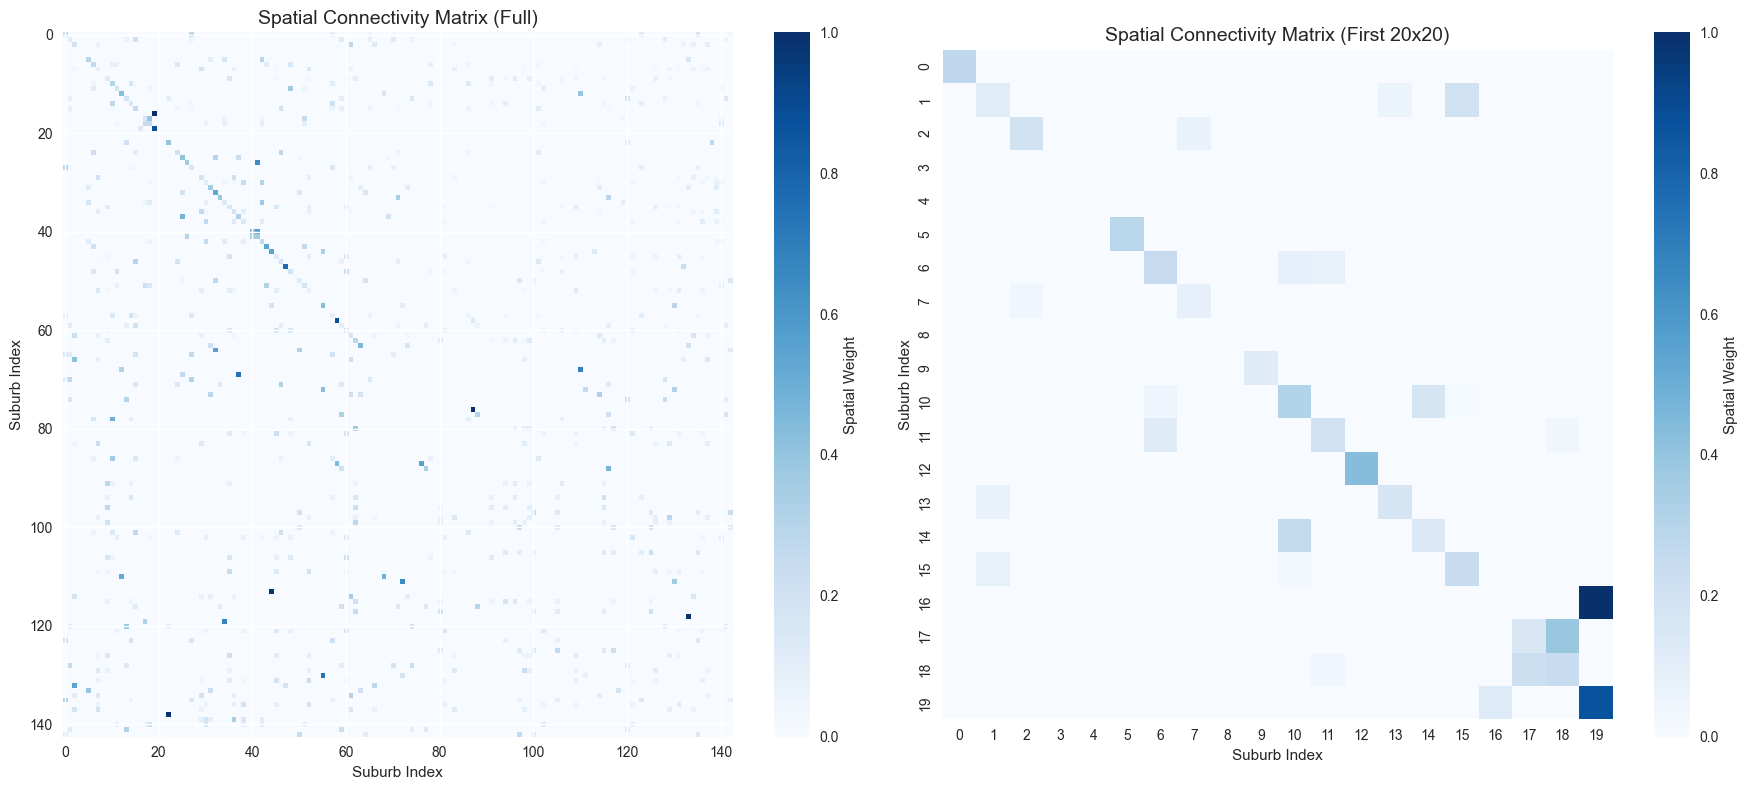

Note: Sparsity of 96.22% indicates sparse spatial connectivity


In [4]:
# Visualize spatial connectivity matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Full matrix
im1 = axes[0].imshow(W, cmap='Blues', aspect='auto')
axes[0].set_title('Spatial Connectivity Matrix (Full)', fontsize=14)
axes[0].set_xlabel('Suburb Index')
axes[0].set_ylabel('Suburb Index')
plt.colorbar(im1, ax=axes[0], label='Spatial Weight')

# Plot 2: Zoom in on first 20x20
n_sample = min(20, W.shape[0])
sns.heatmap(W[:n_sample, :n_sample], cmap='Blues', square=True, 
            cbar_kws={'label': 'Spatial Weight'}, ax=axes[1])
axes[1].set_title(f'Spatial Connectivity Matrix (First {n_sample}x{n_sample})', fontsize=14)
axes[1].set_xlabel('Suburb Index')
axes[1].set_ylabel('Suburb Index')

plt.tight_layout()
plt.show()

print(f"Note: Sparsity of {sparsity:.2%} indicates" + 
      (" no spatial connectivity defined" if sparsity > 0.99 else " sparse spatial connectivity"))


## 3. Data Preparation and Feature Engineering


In [5]:
# Create mapping between spatial units and matrix indices

# Check overlap between data suburbs and matrix suburbs
data_suburbs = set(df['suburb'].unique())
matrix_suburbs = set(suburbs_in_matrix)

overlap = data_suburbs.intersection(matrix_suburbs)
print(f"Suburbs in data: {len(data_suburbs)}")
print(f"Suburbs in matrix: {len(matrix_suburbs)}")
print(f"Overlapping suburbs: {len(overlap)}")

if len(overlap) < len(data_suburbs):
    print(f"\nWarning: {len(data_suburbs) - len(overlap)} suburbs in data not found in connectivity matrix")
    missing_suburbs = data_suburbs - matrix_suburbs
    print(f"Sample of missing suburbs: {list(missing_suburbs)[:5]}")

# Create suburb to matrix index mapping
suburb_to_idx = {suburb: idx for idx, suburb in enumerate(suburbs_in_matrix)}

# Add matrix index to dataframe (will be NaN for suburbs not in matrix)
df['suburb_matrix_idx'] = df['suburb'].map(suburb_to_idx)


Suburbs in data: 143
Suburbs in matrix: 143
Overlapping suburbs: 143


In [6]:
# Sort data by spatial unit and time
df = df.sort_values(['spatial_index', 'time_index']).reset_index(drop=True)

# Create time-lagged features (1 to 4 quarters)
print("Creating time-lagged features...")
for lag in range(1, 5):
    df[f'rent_lag_{lag}'] = df.groupby('spatial_index')['median_rent'].shift(lag)
    print(f"  Created rent_lag_{lag}")

print("\nTime-lagged features created successfully")


Creating time-lagged features...
  Created rent_lag_1
  Created rent_lag_2
  Created rent_lag_3
  Created rent_lag_4

Time-lagged features created successfully


In [ ]:
# Create spatial lag features
def create_spatial_lags(df, W, suburb_to_idx):
    """Create spatial lag variables based on connectivity matrix"""
    spatial_lags = np.zeros(len(df))
    
    for idx, row in df.iterrows():
        if idx % 10000 == 0:
            print(f"  Processing row {idx}/{len(df)}...")
        
        suburb = row['suburb']
        
        # Skip if suburb not in matrix
        if pd.isna(row['suburb_matrix_idx']):
            continue
            
        suburb_idx = int(row['suburb_matrix_idx'])
        time_idx = row['time_index']
        
        # Calculate spatial lag as weighted average of neighbors at same time
        spatial_lag = 0
        total_weight = 0
        
        for neighbor_idx, weight in enumerate(W[suburb_idx, :]):
            if weight > 0:  # If there's a connection
                # Find all observations from this neighbor at this time
                neighbor_suburb = suburbs_in_matrix[neighbor_idx]
                neighbor_data = df[(df['suburb'] == neighbor_suburb) & 
                                 (df['time_index'] == time_idx)]
                
                if not neighbor_data.empty:
                    # Average rent across all property types for this neighbor
                    neighbor_rent = neighbor_data['median_rent'].mean()
                    if not pd.isna(neighbor_rent):
                        spatial_lag += weight * neighbor_rent
                        total_weight += weight
        
        # Normalize by total weight if any neighbors found
        if total_weight > 0:
            spatial_lags[idx] = spatial_lag / total_weight
    
    return spatial_lags

print("Creating spatial lag features...")
df['spatial_lag'] = create_spatial_lags(df, W, suburb_to_idx)
print("\nSpatial lag features created successfully")

# Check spatial lag statistics
print(f"\nSpatial lag statistics:")
print(f"  Non-zero spatial lags: {(df['spatial_lag'] > 0).sum()} / {len(df)}")
print(f"  Mean spatial lag: {df[df['spatial_lag'] > 0]['spatial_lag'].mean():.2f}")
print(f"  Std spatial lag: {df[df['spatial_lag'] > 0]['spatial_lag'].std():.2f}")


Creating spatial lag features...
  Processing row 0/41918...


In [ ]:
# Define weights for unreliable periods (COVID-19 pandemic)
# Downweight 2020-2021 observations
df['weights'] = np.where((df['year'] >= 2020) & (df['year'] <= 2021), 0.1, 1.0)
df['is_unreliable'] = (df['year'] >= 2020) & (df['year'] <= 2021)

print(f"Unreliable observations (2020-2021): {df['is_unreliable'].sum()}")
print(f"Weight distribution:")
print(df['weights'].value_counts())


In [ ]:
# Remove rows with NaN values in key features
# NOTE: We also check spatial_lag to ensure we only keep rows with valid spatial information
df_clean = df.dropna(subset=['median_rent', 'rent_lag_1', 'rent_lag_2', 
                              'rent_lag_3', 'rent_lag_4', 'spatial_lag']).reset_index(drop=True)

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Removed {len(df) - len(df_clean)} rows with missing values")
print(f"\nClean dataset summary:")
print(f"  Spatial units: {df_clean['spatial_unit'].nunique()}")
print(f"  Time periods: {df_clean['date'].nunique()}")
print(f"  Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")


In [ ]:
# Save cleaned dataset for future use
import os

output_dir = '../data/curated/rent_growth'
os.makedirs(output_dir, exist_ok=True)

# Save as CSV
csv_path = os.path.join(output_dir, 'df_clean.csv')
df_clean.to_csv(csv_path, index=False)
print(f"✓ Saved cleaned dataset to CSV: {csv_path}")
print(f"  Shape: {df_clean.shape}")
print(f"  Size: {os.path.getsize(csv_path) / (1024**2):.2f} MB")

# Save as pickle (preserves dtypes and is faster to load)
pkl_path = os.path.join(output_dir, 'df_clean.pkl')
df_clean.to_pickle(pkl_path)
print(f"\n✓ Saved cleaned dataset to pickle: {pkl_path}")
print(f"  Size: {os.path.getsize(pkl_path) / (1024**2):.2f} MB")

print(f"\n{'='*60}")
print("Cleaned dataset saved successfully!")
print(f"{'='*60}")
print("\nTo load the data later:")
print("  # CSV (slower, human-readable)")
print("  df_clean = pd.read_csv('../data/curated/rent_growth/df_clean.csv')")
print("\n  # Pickle (faster, preserves dtypes)")
print("  df_clean = pd.read_pickle('../data/curated/rent_growth/df_clean.pkl')")
print(f"{'='*60}")
